# London Smart Meters ML
### Thomas Rosenthal

- You must have pandas 1.1.0
- You must have at least 16gb of RAM to run this

In [1]:
#conda install pandas=1.1.0
#pip install pandas=1.1.0

### Load Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime as dt
import random
import joblib
from collections import Counter
print(pd.__version__) #needs to be 1.1.0

1.1.0


In [3]:
from numpy import pi, sin

In [4]:
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [142]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, balanced_accuracy_score

In [6]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
from sklearn.svm import SVC

Set random.seed(42) to ensure models could be reproduced...the number itself is irrelevant, just a constant in an otherwise meaningless universe

In [9]:
np.random.seed(42)

## Load Data

### File Loading loop

In [10]:
file_list = []
for dirname, _, filenames in os.walk('Datasources/'):
    for filename in filenames:
        if '.csv' in filename and '.gz' not in filename:
            file_list.append(os.path.join(dirname, filename))

### Load Tariffs

In [11]:
tariffs = pd.read_excel('Datasources/Tariffs.xlsx')
print(tariffs.dtypes)
tariffs.head()

TariffDateTime    datetime64[ns]
Tariff                    object
dtype: object


,TariffDateTime,Tariff
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


Add Month, Day, Time, AM/PM, "tariffs_extended"

In [12]:
tariffs_extended = tariffs.copy()
tariffs_extended['month'] =  pd.DatetimeIndex(tariffs['TariffDateTime']).month
tariffs_extended['day'] =  pd.DatetimeIndex(tariffs['TariffDateTime']).day
tariffs_extended['time'] = pd.DatetimeIndex(tariffs['TariffDateTime']).time
tariffs_extended['AM'] = pd.to_datetime(tariffs_extended['TariffDateTime']).dt.strftime('%p')
tariffs_extended['TariffDateTime'] = pd.to_datetime(tariffs_extended['TariffDateTime'])

### Load Households (acorn groups)

In [13]:
households = pd.read_csv('Datasources/informations_households.csv')
households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


We'll only be working with thre Acorn groups: 
'Affluent','Comfortable','Adversity' 

In [14]:
print(households.Acorn_grouped.unique())

['ACORN-' 'Affluent' 'Comfortable' 'Adversity' 'ACORN-U']


Explore the demographic details of each block, by Acorn, Block Name, and whether or not they were in the dynamic or standard pricing scheme.

_(This table helped me determine which block to select for ML models, see halfhourly section for details)_

In [15]:
pd.set_option('display.max_rows', 300) #so we can see all of them
households.groupby(['Acorn_grouped', 'file','stdorToU']).agg('count')

LCLid  Acorn
Acorn_grouped file      stdorToU              
ACORN-        block_0   ToU           2      2
ACORN-U       block_110 Std          27     27
                        ToU           6      6
              block_111 Std          12     12
                        ToU           4      4
Adversity     block_100 Std          49     49
                        ToU           1      1
              block_101 Std          50     50
              block_102 Std          50     50
              block_103 Std          49     49
                        ToU           1      1
              block_104 Std          43     43
                        ToU           7      7
              block_105 Std          37     37
                        ToU          13     13
              block_106 Std          32     32
                        ToU          18     18
              block_107 Std          39     39
                        ToU          11     11
              block_108 Std          50     50
              block_109 Std          41     41
                        ToU           9      9
              block_110 Std          15     15
                        ToU           2      2
              block_74  Std          43     43
                        ToU           6      6
              block_75  Std          44     44
                        ToU           6      6
              block_76  Std          45     45
                        ToU           5      5
              block_77  Std          36     36
                        ToU          14     14
              block_78  Std          28     28
                        ToU          22     22
              block_79  Std          31     31
                        ToU          19     19
              block_80  Std          33     33
                        ToU          17     17
              block_81  Std          49     49
                        ToU           1      1
              block_82  Std          45     45
                        ToU           5      5
              block_83  Std          47     47
                        ToU           3      3
              block_84  Std          43     43
                        ToU           7      7
              block_85  Std          42     42
                        ToU           8      8
              block_86  Std          41     41
                        ToU           9      9
              block_87  Std          40     40
                        ToU          10     10
              block_88  Std          44     44
                        ToU           6      6
              block_89  Std          41     41
                        ToU           9      9
              block_90  Std          44     44
                        ToU           6      6
              block_91  Std          38     38
                        ToU          12     12
              block_92  Std          41     41
                        ToU           9      9
              block_93  Std          40     40
                        ToU          10     10
              block_94  Std          37     37
                        ToU          13     13
              block_95  Std          36     36
                        ToU          14     14
              block_96  Std          37     37
                        ToU          13     13
              block_97  Std          42     42
                        ToU           8      8
              block_98  Std          46     46
                        ToU           4      4
              block_99  Std          50     50
Affluent      block_0   Std          48     48
              block_1   Std          50     50
              block_10  Std          33     33
                        ToU          17     17
              block_11  Std          42     42
                        ToU           8      8
              block_12  Std          43     43
                        ToU           7      7
              block_13  Std          50

Get the block number as it's own column, from the filename 

In [16]:
households['block_str'] = households['file'].str.split(pat="_", expand=True)[1]

In [17]:
households["block"] = pd.to_numeric(households["block_str"])
del households['block_str']

In [18]:
households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file,block
0,MAC005492,ToU,ACORN-,ACORN-,block_0,0
1,MAC001074,ToU,ACORN-,ACORN-,block_0,0
2,MAC000002,Std,ACORN-A,Affluent,block_0,0
3,MAC003613,Std,ACORN-A,Affluent,block_0,0
4,MAC003597,Std,ACORN-A,Affluent,block_0,0


### Half hourly files

Originally, I worked with and manipulated the entire dataset during my EDA.

After narrowing my scope, I have filtered the /halfhourly_dataset/halfhourly_dataset/ subdirectory to three blocks
- Block 16
- Block 64
- Block 78

The other blocks were moved to /halfhourly_dataset/overflow

Final testing blocks were moved to /halfhourly_dataset/test and are loaded later
- Block 37
- Block 63
- Block 79

In [19]:
hh_files = [d for d in file_list if '/halfhourly_dataset/halfhourly_dataset/b' in d]

In [20]:
#warning, high memory usage...at least 8gb required, 16gb+ recommended if you load all
halfhourly = (pd.concat(pd.read_csv(d) for d in hh_files))
halfhourly.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000008,2012-05-05 09:00:00.0000000,0.256
1,MAC000008,2012-05-05 09:30:00.0000000,0.862
2,MAC000008,2012-05-05 10:00:00.0000000,0.768
3,MAC000008,2012-05-05 10:30:00.0000000,0.54
4,MAC000008,2012-05-05 11:00:00.0000000,0.457


In [21]:
halfhourly['tstp'] = pd.to_datetime(halfhourly['tstp'])

Add Year, Month

In [22]:
halfhourly['year'] =  pd.DatetimeIndex(halfhourly['tstp']).year
halfhourly['month'] =  pd.DatetimeIndex(halfhourly['tstp']).month

Filter to 2013 for Pilot Year, "halfhourly_2013"

In [23]:
is_2013 =  halfhourly['year']==2013
halfhourly_2013 = halfhourly[is_2013]

In [24]:
del halfhourly #originally the final dataset size was (167817021, 5), this deletion is for memory management 

## Wrangling

### Combine Tariff and Halfhourly in dataframe, "merged"

In [25]:
merged = pd.merge(halfhourly_2013,tariffs_extended,how="inner",left_on="tstp",right_on="TariffDateTime")
merged.head()

,LCLid,tstp,energy(kWh/hh),year,month_x,TariffDateTime,Tariff,month_y,day,time,AM
0,MAC000008,2013-01-01,0.244,2013,1,2013-01-01,Normal,1,1,00:00:00,AM
1,MAC000059,2013-01-01,0.412,2013,1,2013-01-01,Normal,1,1,00:00:00,AM
2,MAC000062,2013-01-01,0.199,2013,1,2013-01-01,Normal,1,1,00:00:00,AM
3,MAC000093,2013-01-01,0.174,2013,1,2013-01-01,Normal,1,1,00:00:00,AM
4,MAC000124,2013-01-01,0.387,2013,1,2013-01-01,Normal,1,1,00:00:00,AM


### Combine Merged and Households in dataframe, "hh_acorns"

In [26]:
hh_acorns = pd.merge(merged, households, on="LCLid", how="left")
hh_acorns.head()

,LCLid,tstp,energy(kWh/hh),year,month_x,TariffDateTime,Tariff,month_y,day,time,AM,stdorToU,Acorn,Acorn_grouped,file,block
0,MAC000008,2013-01-01,0.244,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-H,Comfortable,block_64,64
1,MAC000059,2013-01-01,0.412,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-H,Comfortable,block_64,64
2,MAC000062,2013-01-01,0.199,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-H,Comfortable,block_64,64
3,MAC000093,2013-01-01,0.174,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-H,Comfortable,block_64,64
4,MAC000124,2013-01-01,0.387,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,ToU,ACORN-H,Comfortable,block_64,64


Cast energy as numeric and create day of the week ("DOW")

In [27]:
hh_acorns["energy"] = pd.to_numeric(hh_acorns["energy(kWh/hh)"])
del hh_acorns['energy(kWh/hh)']

In [28]:
hh_acorns["DOW"] = pd.DatetimeIndex(hh_acorns['tstp']).dayofweek

Groupby unique values, this will determine the data grain from which we will sample

In [29]:
hh_acorns.groupby(['Acorn_grouped', 'file','stdorToU']).agg(pd.Series.nunique)

LCLid   tstp  year  month_x  TariffDateTime  \
Acorn_grouped file     stdorToU                                                
Adversity     block_78 Std          28  17520     1       12           17520   
                       ToU          22  17520     1       12           17520   
Affluent      block_16 Std          25  17520     1       12           17520   
                       ToU          25  17520     1       12           17520   
Comfortable   block_64 Std          32  17520     1       12           17520   
                       ToU          18  17520     1       12           17520   

                                 Tariff  month_y  day  time  AM  Acorn  block  \
Acorn_grouped file     stdorToU                                                 
Adversity     block_78 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Affluent      block_16 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Comfortable   block_64 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   

                                 energy  DOW  
Acorn_grouped file     stdorToU               
Adversity     block_78 Std       2159.0    7  
                       ToU       2102.0    7  
Affluent      block_16 Std       2620.0    7  
                       ToU       2379.0    7  
Comfortable   block_64 Std       2111.0    7  
                       ToU       2747.0    7

## Prepare Data for Machine Learning

### Create 25% sample. "hh_acorn_sample"
Build the sample based on:
- Acorn_grouped (we'll have our three groups)
- Price scheme
- Every day within the year
- Every half hour within the year

This will group value to sample from ID's

In [30]:
hh_acorn_sample = hh_acorns.groupby(['Acorn_grouped','stdorToU','tstp','time']).sample(frac = .25, random_state = 1)

Compare to previous hh_acorns groupby:

- Energy has decreased
- hh_acorns shape is: (2541570, 17)
- hh_acorn_sample shape is: (625729, 17)

In [31]:
hh_acorn_sample.groupby(['Acorn_grouped', 'file','stdorToU',]).agg(pd.Series.nunique)

LCLid   tstp  year  month_x  TariffDateTime  \
Acorn_grouped file     stdorToU                                                
Adversity     block_78 Std          28  17520     1       12           17520   
                       ToU          22  17520     1       12           17520   
Affluent      block_16 Std          25  17520     1       12           17520   
                       ToU          25  17520     1       12           17520   
Comfortable   block_64 Std          32  17520     1       12           17520   
                       ToU          18  17520     1       12           17520   

                                 Tariff  month_y  day  time  AM  Acorn  block  \
Acorn_grouped file     stdorToU                                                 
Adversity     block_78 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Affluent      block_16 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Comfortable   block_64 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   

                                 energy  DOW  
Acorn_grouped file     stdorToU               
Adversity     block_78 Std       1717.0    7  
                       ToU       1723.0    7  
Affluent      block_16 Std       1976.0    7  
                       ToU       1933.0    7  
Comfortable   block_64 Std       1754.0    7  
                       ToU       1913.0    7

In [32]:
hh_acorns.shape

(2541570, 17)

In [33]:
hh_acorn_sample.shape

(625729, 17)

In [34]:
del hh_acorns #more memory cleaning

### Prepare data for ML models, "ml_households"

In [35]:
ml_households = hh_acorn_sample.copy()

Our current dataframe

In [36]:
ml_households.head()

,LCLid,tstp,year,month_x,TariffDateTime,Tariff,month_y,day,time,AM,stdorToU,Acorn,Acorn_grouped,file,block,energy,DOW
146,MAC005478,2013-01-01,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-L,Adversity,block_78,78,0.056,1
127,MAC002423,2013-01-01,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-L,Adversity,block_78,78,0.138,1
129,MAC002431,2013-01-01,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-L,Adversity,block_78,78,0.058,1
142,MAC005058,2013-01-01,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-L,Adversity,block_78,78,0.072,1
124,MAC002377,2013-01-01,2013,1,2013-01-01,Normal,1,1,00:00:00,AM,Std,ACORN-L,Adversity,block_78,78,0.192,1


Remove irrelvent columns

In [37]:
# column indicies
# LCLid, 0
# tstp, 1
# year, 2
# month_x, 3
# TariffDateTime, 4
# Tariff, 5
# month_y, 6
# day, 7
# time, 8
# AM, 9
# stdorToU, 10
# Acorn, 11
# Acorn_grouped, 12
# file, 13
# block, 14
# energy, 15
# DOW, 16

ml_households = ml_households.drop(ml_households.columns[[0, 1, 2, 3, 4, 7, 9, 11, 13, 14]], axis=1)

In [38]:
ml_households.head()

,Tariff,month_y,time,stdorToU,Acorn_grouped,energy,DOW
146,Normal,1,00:00:00,Std,Adversity,0.056,1
127,Normal,1,00:00:00,Std,Adversity,0.138,1
129,Normal,1,00:00:00,Std,Adversity,0.058,1
142,Normal,1,00:00:00,Std,Adversity,0.072,1
124,Normal,1,00:00:00,Std,Adversity,0.192,1


Transform Timestamps into halfhour increments, 'halfhour', where 00:00:00 (midnight) = 0, and 23:30:00 = 47

In [39]:
timeStr_ml = ml_households.time.astype(str).str.split(":")

In [40]:
def halfhourinc(df,timestring):
    empty = []
    for i in timestring:
        if int(i[1]) != 30:
            empty.append(int(i[0])*2)
        else:
            empty.append(int(i[0])*2+1)
    df['halfhour'] = empty

In [41]:
halfhourinc(ml_households,timeStr_ml)

In [42]:
del ml_households['time']

### Explore relationship between acorn, price scheme, and energy usage

In [43]:
pd.set_option('display.max_rows', 10) 
ml_households.groupby(['Acorn_grouped','stdorToU','halfhour']).agg(pd.Series.nunique)

Tariff  month_y  energy  DOW
Acorn_grouped stdorToU halfhour                              
Adversity     Std      0              3       12   469.0    7
                       1              3       12   424.0    7
                       2              3       12   393.0    7
                       3              3       12   353.0    7
                       4              3       12   316.0    7
...                                 ...      ...     ...  ...
Comfortable   ToU      43             3       12   553.0    7
                       44             3       12   507.0    7
                       45             3       12   499.0    7
                       46             3       12   462.0    7
                       47             3       12   433.0    7

[288 rows x 4 columns]

In [44]:
hold = ml_households.groupby(['Acorn_grouped','stdorToU','halfhour']).agg(pd.Series.nunique).reset_index(drop=False)

In [45]:
ml_hold_df = pd.DataFrame(data = hold)

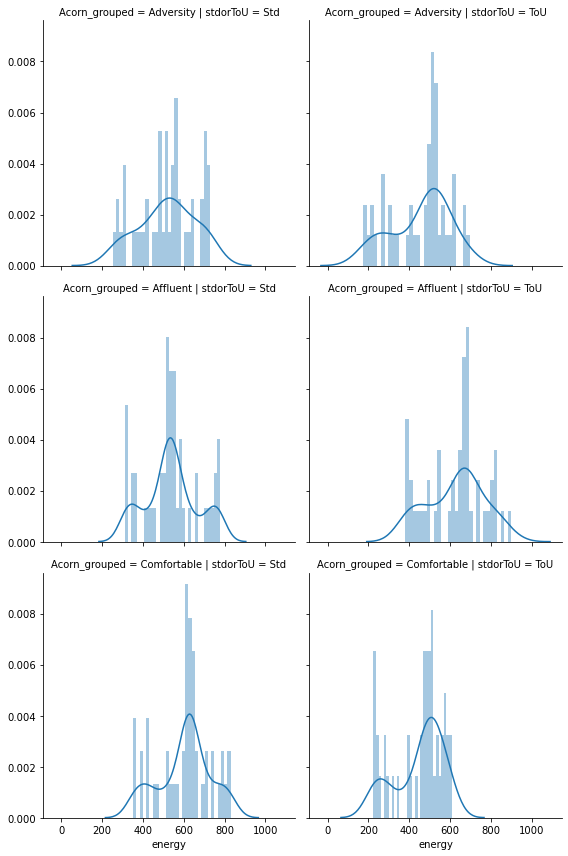

In [46]:
histograms = sns.FacetGrid(ml_hold_df, col='stdorToU',row='Acorn_grouped',height = 4)
histograms = histograms.map(sns.distplot, 'energy', bins=30)
plt.show()

In [47]:
mo_hold = ml_households.groupby(['Acorn_grouped', 'stdorToU','month_y']).agg(group=('Acorn_grouped', 'first'),
                              ToU=('stdorToU','first'),
                              month=('month_y', 'first'),
                              avg_daily_energy=('energy', 'mean'),
                              med_daily_energy=('energy', 'median')
                             )

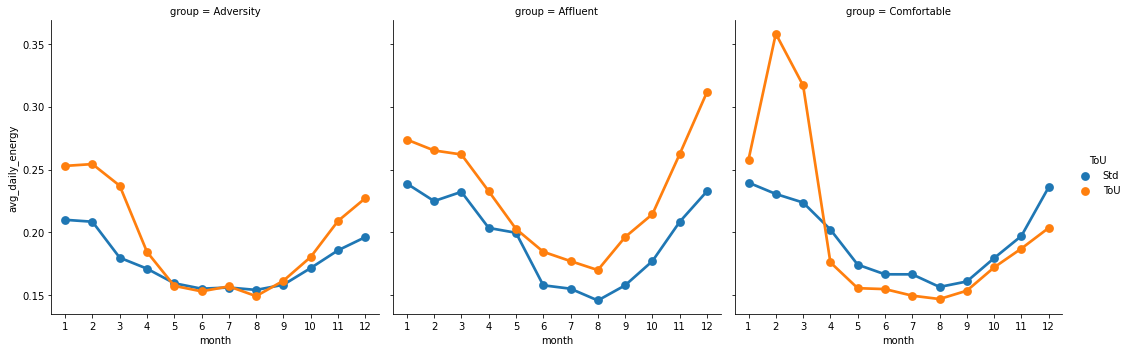

In [48]:
ax = sns.catplot(y="avg_daily_energy", x="month", col="group", hue="ToU", data=mo_hold, kind="point")

In [49]:
month_hold = ml_households.groupby([ 'stdorToU','month_y']).agg(
                              ToU=('stdorToU','first'),
                              month=('month_y', 'first'),
                              avg_daily_energy=('energy', 'mean'),
                              med_daily_energy=('energy', 'median')
                             )

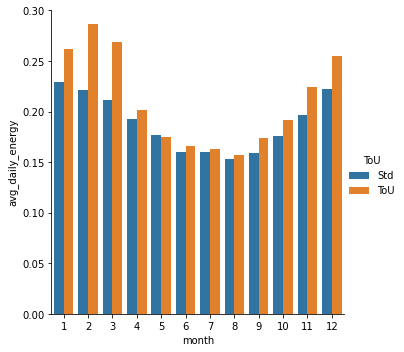

In [50]:
ax = sns.catplot(y="avg_daily_energy", x="month", hue="ToU", data=month_hold, kind="bar")

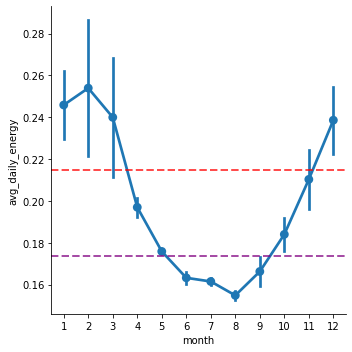

In [51]:
ax = sns.catplot(y="avg_daily_energy", x="month", data=month_hold, kind="point")
ax.axes[0][0].axhline(y = .215, color='red', linewidth=2, alpha=.7, ls='--')
ax.axes[0][0].axhline(y = .1735, color='purple', linewidth=2, alpha=.7, ls='--')

### Transform non-numeric values into dummies
- stdorToU to binary
- Acorn_grouped to dummies

In [52]:
ml_households = pd.get_dummies(ml_households,columns = ['stdorToU'])

In [53]:
del ml_households['stdorToU_Std']
ml_households.head()

,Tariff,month_y,Acorn_grouped,energy,DOW,halfhour,stdorToU_ToU
146,Normal,1,Adversity,0.056,1,0,0
127,Normal,1,Adversity,0.138,1,0,0
129,Normal,1,Adversity,0.058,1,0,0
142,Normal,1,Adversity,0.072,1,0,0
124,Normal,1,Adversity,0.192,1,0,0


Acorn dummies reference:
    
|             | Acorn_grouped_Adversity | Acorn_grouped_Affluent |
|-------------|-------------------------|------------------------|
| Adversity   | 1                       | 0                      |
| Affluent    | 0                       | 1                      |
| Comfortable | 0                       | 0                      |

In [54]:
ml_households = pd.get_dummies(ml_households,columns = ['Acorn_grouped'])

In [55]:
del ml_households['Acorn_grouped_Comfortable']
ml_households.head()

,Tariff,month_y,energy,DOW,halfhour,stdorToU_ToU,Acorn_grouped_Adversity,Acorn_grouped_Affluent
146,Normal,1,0.056,1,0,0,1,0
127,Normal,1,0.138,1,0,0,1,0
129,Normal,1,0.058,1,0,0,1,0
142,Normal,1,0.072,1,0,0,1,0
124,Normal,1,0.192,1,0,0,1,0


### Check for Correlation among variables

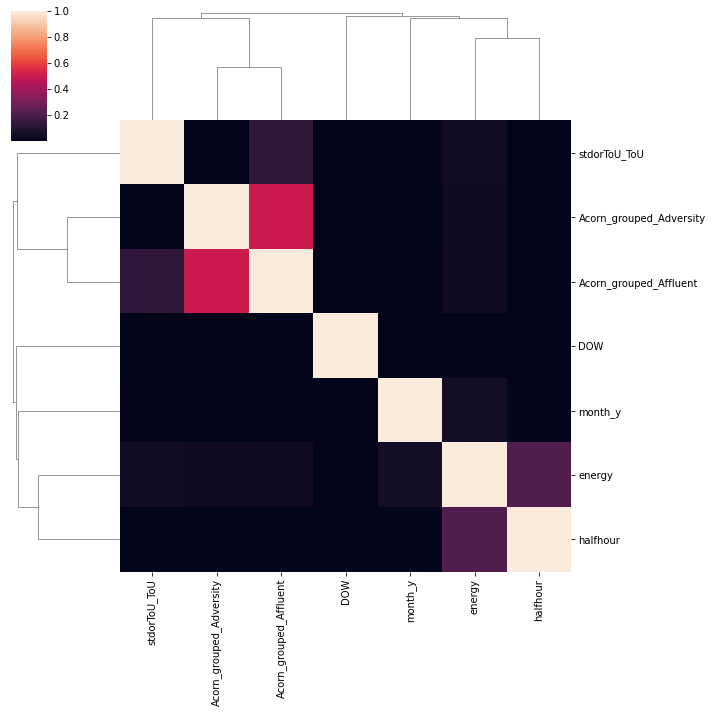

In [56]:
sns.clustermap(abs(ml_households.corr()))

Corrplot shows no correlation

### Normalize (MinMaxScalar) data

Energy will be normalized.

In [57]:
scaler = preprocessing.MinMaxScaler()
ml_households[['energy']] = scaler.fit_transform(ml_households[['energy']])
ml_households.head()

,Tariff,month_y,energy,DOW,halfhour,stdorToU_ToU,Acorn_grouped_Adversity,Acorn_grouped_Affluent
146,Normal,1,0.010967,1,0,0,1,0
127,Normal,1,0.027027,1,0,0,1,0
129,Normal,1,0.011359,1,0,0,1,0
142,Normal,1,0.014101,1,0,0,1,0
124,Normal,1,0.037603,1,0,0,1,0


### Cyclical Tranformations

Some research into Halfhour and Month has suggested that rather than encoding these variables, I use sine/cosine transformations to maintain the cyclical relationships of these variables.

This is done for halfhour and month variables

In [58]:
ml_households['halfhour_sin'] = np.sin(ml_households['halfhour']*(2.*np.pi/48))
ml_households['halfhour_cos'] = np.cos(ml_households['halfhour']*(2.*np.pi/48))

In [59]:
ml_households['month_sin'] = np.sin((ml_households['month_y']-1)*(2.*np.pi/12))
ml_households['month_cos'] = np.cos((ml_households['month_y']-1)*(2.*np.pi/12))

In [60]:
ml_households['DOW_sin'] = np.sin(ml_households['DOW']*(2.*np.pi/7))
ml_households['DOW_cos'] = np.cos(ml_households['DOW']*(2.*np.pi/7))

In [61]:
del ml_households['halfhour']

In [62]:
ml_households.head()

,Tariff,month_y,energy,DOW,stdorToU_ToU,Acorn_grouped_Adversity,Acorn_grouped_Affluent,halfhour_sin,halfhour_cos,month_sin,month_cos,DOW_sin,DOW_cos
146,Normal,1,0.010967,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
127,Normal,1,0.027027,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
129,Normal,1,0.011359,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
142,Normal,1,0.014101,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
124,Normal,1,0.037603,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349


## Modelling

### Epoch Splitting

Instead of a standard train test split:

    #X = ml_households.drop(["Tariff"], axis = 1)
    #y = ml_households.iloc[:,0].values

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
We'll stratify on Day of Week (DOW).

In [63]:
ml_households.DOW.unique()

array([1, 2, 3, 4, 5, 6, 0])

_Monday represents 0 in Python for DOW_

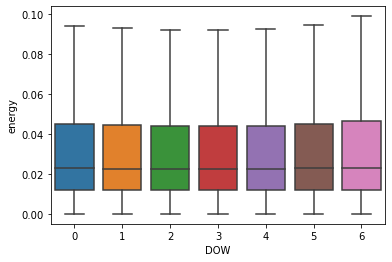

In [64]:
ax = sns.boxplot(y="energy", x="DOW", data=ml_households, orient="v", showfliers = False)

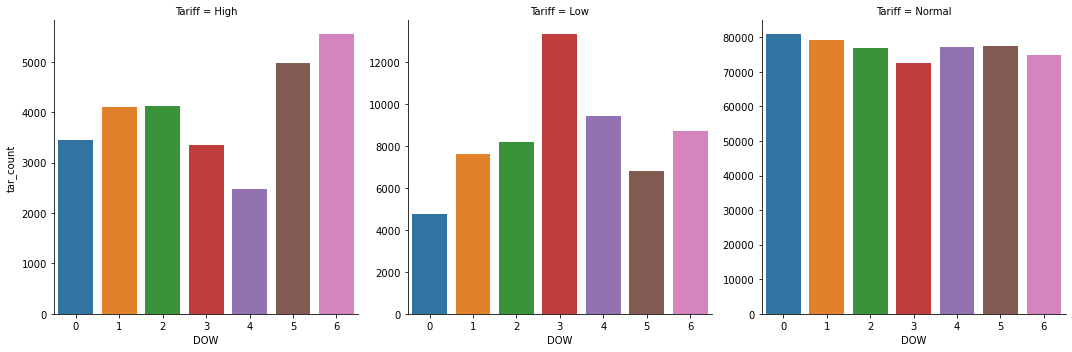

In [65]:
pd.set_option('display.max_rows', 21)
tar_hold = ml_households.groupby(['DOW','Tariff']).agg(tar_count =("Tariff", 'count')).reset_index()


ax = sns.catplot(y="tar_count", x="DOW", col="Tariff", data=tar_hold, kind="bar", sharey=False)

Putting Sunday (6) and Tuesday (1) in our Testset.

The reasoning - we want one weekday, one weekend:
- Deciding between Saturday (5) and Sunday (6) is difficult. Sunday has more High Tariffs than Saturday, and slightly more energy usage than Saturday. Despite this, our training set wil likely see that Saturday has significantly more High tariffs than any other day, and nearly the Lowest number of Low (aside from Monday). 
- Tuesday (1) is an ideal weekday because it is essentially the average weekday. It has the least remarkable Tariff distribution (neither highest, nor lowest for any day). It is on par with energy usage as other weekdays.

In [107]:
X_train = ml_households.query('DOW != 1 and DOW != 6').drop(["Tariff","DOW","month_y"], axis = 1)
X_test = ml_households.query('DOW == 1 or DOW == 6').drop(["Tariff","DOW","month_y"], axis = 1) 
y_train = ml_households.query('DOW != 1 and DOW != 6').iloc[:,0].values
y_test = ml_households.query('DOW == 1 or DOW == 6').iloc[:,0].values 

Our train:test split is 71.5:28.5

Originally 625729 rows (ml_households)
- X_train = (445760, 8)
- X_test = (179969, 8)

Alternative, seasonal

In [67]:
X_train_season = ml_households.query('month_y != 1 and month_y != 4 and month_y != 7 and month_y != 10').drop(["Tariff","DOW","month_y"], axis = 1)
X_test_season = ml_households.query('month_y == 1 or month_y == 4 or month_y == 7 or month_y == 10').drop(["Tariff","DOW","month_y"], axis = 1) 
y_train_season = ml_households.query('month_y != 1 and month_y != 4 and month_y != 7 and month_y != 10').iloc[:,0].values
y_test_season = ml_households.query('month_y == 1 or month_y == 4 or month_y == 7 or month_y == 10').iloc[:,0].values 

Alternative, "cold, mild, warm"

In [68]:
X_train_temp = ml_households.query('month_y != 5 and month_y != 7 and month_y != 12').drop(["Tariff","DOW","month_y"], axis = 1)
X_test_temp = ml_households.query('month_y == 5 or month_y == 7 or month_y == 12').drop(["Tariff","DOW","month_y"], axis = 1) 
y_train_temp = ml_households.query('month_y != 5 and month_y != 7 and month_y != 12').iloc[:,0].values
y_test_temp = ml_households.query('month_y == 5 or month_y == 7 or month_y == 12').iloc[:,0].values 

### KNN 

KNN is nice first model for a dataset with a low number of distinct features. (This model has 10 features to predict 3 class labels.)

Default Parameter for KNeighborsClassifier(), model accuracy = 82%

In [143]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_expect = y_test

print(confusion_matrix(y_test, y_pred))

[[   279    298   9077]
 [   182    370  15796]
 [  2988   3451 147528]]


In [144]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.08      0.03      0.04      9654
         Low       0.09      0.02      0.04     16348
      Normal       0.86      0.96      0.90    153967

    accuracy                           0.82    179969
   macro avg       0.34      0.34      0.33    179969
weighted avg       0.74      0.82      0.78    179969



In [145]:
balanced_accuracy_score(y_expect, y_pred)

0.3365706753065576

Model discussion:
Default parameters are a poor result. Recall is far too low for High and Low labels. 

Normal labels will produce a mid-80's accuracy, so we need to aim for higher recall for those class labels.

__for loop__

Instead of GridSearchCV, I will use for loops for each set of model parameters and save their respective accuracy scores for each combination of results

_Three parameters to be explored_
1. Metric, which distance
    - euclidean
    - manhattan
    - minkowski (generalization distance metric)
2. Weights, how the nearness is measured
    - Uniform
    - Distance, 
3. K (n_neighbors)
    - Testing with odd integers between 1 and 52

In [110]:
KNN_results = []

metric = ['euclidean','manhattan','minkowski']
weights = ['uniform','distance']
for i in range(1, 52 ,2):
    for m in metric:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors= i,
                                       weights = w,metric = m )
            knn.fit(X_train, y_train)
            pred_knn =  knn.predict(X_test)
            accuracy = accuracy_score(y_test,pred_knn)
            KNN_results.append([i,m,w,accuracy])

In [111]:
KNN_results

[[1, 'euclidean', 'uniform', 0.7685712539381783],
 [1, 'euclidean', 'distance', 0.7685712539381783],
 [1, 'manhattan', 'uniform', 0.761781195650362],
 [1, 'manhattan', 'distance', 0.761781195650362],
 [1, 'minkowski', 'uniform', 0.7685712539381783],
 [1, 'minkowski', 'distance', 0.7685712539381783],
 [3, 'euclidean', 'uniform', 0.8087226133389639],
 [3, 'euclidean', 'distance', 0.8109174357806067],
 [3, 'manhattan', 'uniform', 0.7936033427979263],
 [3, 'manhattan', 'distance', 0.7957314870894432],
 [3, 'minkowski', 'uniform', 0.8087226133389639],
 [3, 'minkowski', 'distance', 0.8109174357806067],
 [5, 'euclidean', 'uniform', 0.8233473542665681],
 [5, 'euclidean', 'distance', 0.8274369474742872],
 [5, 'manhattan', 'uniform', 0.8109063227555857],
 [5, 'manhattan', 'distance', 0.8163906006034373],
 [5, 'minkowski', 'uniform', 0.8233473542665681],
 [5, 'minkowski', 'distance', 0.8274369474742872],
 [7, 'euclidean', 'uniform', 0.8329434513721807],
 [7, 'euclidean', 'distance', 0.83557723830

Best KNN result: metric='manhattan', n_neighbors=3, weights='distance'

In [150]:
best_KNN = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
best_KNN.fit(X_train, y_train)

y_pred= best_KNN.predict(X_test)
y_expect = y_test

print(confusion_matrix(y_test, y_pred))

[[   774    536   8344]
 [   559   1117  14672]
 [  5133   7518 141316]]


In [151]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.12      0.08      0.10      9654
         Low       0.12      0.07      0.09     16348
      Normal       0.86      0.92      0.89    153967

    accuracy                           0.80    179969
   macro avg       0.37      0.36      0.36    179969
weighted avg       0.75      0.80      0.77    179969



Model discussion:
Hypertuned parameters are a poor result. Recall is far too low for High and Low labels. 

### RF

In general, this classification problem seems like it will benefit largely from decision trees, but has enough independent starting points to utilize Random Forest algorithms to help pick the best possible tree.

Default Parameter for RandomForestClassifier(), model accuracy = 83%

In [114]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_expect = y_test

print(confusion_matrix(y_test, y_pred))

[[   199    246   9209]
 [    91    331  15926]
 [  2796   2544 148627]]


In [115]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.06      0.02      0.03      9654
         Low       0.11      0.02      0.03     16348
      Normal       0.86      0.97      0.91    153967

    accuracy                           0.83    179969
   macro avg       0.34      0.34      0.32    179969
weighted avg       0.74      0.83      0.78    179969



Model discussion:
Default parameters are a poor result. Recall is far too low for High and Low labels. 

__for loop__

_Four parameters to be explored_
1. n_estimators, how many trees
    - 5, 25, 50, 100, 250, 500
2. min_samples_split, the number of samples required to split a node
    - 2, 5, 10, 15, 100
3. min_samples_leaf, the number of samples required to create a leaf
    - 1, 2, 5, 10
4. max_depth, how deep the RF will go
    - 2, 4, 8, 16, 32, None

Train:Test discussion: all combinations of train:test Epoch criteria were tested on parameters and no better outcome was found. Model outcomes were unaffected. 

Normalization/Cyclical discussion: leaving month, halfhour, DOW as integers and leaving energy as an unscaled variable was tested in some combinations. Model outcomes were generally unaffected, with no significant standout methodology.

In [116]:
RF_results = []

max_depth = [16, 32, None]
for i in [5, 25, 50, 100, 250, 500]:
    for md in max_depth:
        RF = RandomForestClassifier(n_estimators= i, max_depth = md )
        RF.fit(X_train, y_train)
        pred_RF =  RF.predict(X_test)
        accuracy_rf = accuracy_score(y_test,pred_RF)
        RF_results.append([i,md,accuracy_rf])

In [118]:
RF_results

[[5, 16, 0.836316254466047],
 [5, 32, 0.802515988864749],
 [5, None, 0.8046330201312448],
 [25, 16, 0.8474737315871067],
 [25, 32, 0.8270535481110636],
 [25, None, 0.8207469064116598],
 [50, 16, 0.8502297617923087],
 [50, 32, 0.8228528246531347],
 [50, None, 0.8264478882474204],
 [100, 16, 0.8495129716784557],
 [100, 32, 0.8280981724630353],
 [100, None, 0.8274647300368396],
 [250, 16, 0.8493296067656096],
 [250, 32, 0.831020898043552],
 [250, None, 0.8313598453066917],
 [500, 16, 0.8502242052797981],
 [500, 32, 0.8316598969822581],
 [500, None, 0.831215375981419]]

In [ ]:
RF_results_deeper = []

min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

max_depth = [2, 4, 8, 16, 32, None]
for i in [5, 25, 50, 100, 250, 500]:
    for md in max_depth:
        for mss in min_samples_split:
            for msl in min_samples_leaf:
                RF = RandomForestClassifier(n_estimators= i, min_samples_split = mss,
                                            min_samples_leaf = msl, max_depth = md )
                RF.fit(X_train, y_train)
                pred_RF =  RF.predict(X_test)
                accuracy_rf = accuracy_score(y_test,pred_RF)
                RF_results_deeper.append([i,mss,msl,md,accuracy_rf])

Truncated slightly due to runtime:

In [157]:
RF_results_deeper

[[5, 2, 1, 2, 0.8555195617022932],
 [5, 2, 2, 2, 0.8555195617022932],
 [5, 2, 5, 2, 0.8555195617022932],
 [5, 2, 10, 2, 0.8555195617022932],
 [5, 5, 1, 2, 0.8555195617022932],
 [5, 5, 2, 2, 0.8555195617022932],
 [5, 5, 5, 2, 0.8555195617022932],
 [5, 5, 10, 2, 0.8555195617022932],
 [5, 10, 1, 2, 0.8555195617022932],
 [5, 10, 2, 2, 0.8555195617022932],
 [5, 10, 5, 2, 0.8555195617022932],
 [5, 10, 10, 2, 0.8555195617022932],
 [5, 15, 1, 2, 0.8555195617022932],
 [5, 15, 2, 2, 0.8555195617022932],
 [5, 15, 5, 2, 0.8555195617022932],
 [5, 15, 10, 2, 0.8555195617022932],
 [5, 100, 1, 2, 0.8555195617022932],
 [5, 100, 2, 2, 0.8555195617022932],
 [5, 100, 5, 2, 0.8555195617022932],
 [5, 100, 10, 2, 0.8555195617022932],
 [5, 2, 1, 4, 0.8555195617022932],
 [5, 2, 2, 4, 0.8555195617022932],
 [5, 2, 5, 4, 0.8555195617022932],
 [5, 2, 10, 4, 0.8555195617022932],
 [5, 5, 1, 4, 0.8555195617022932],
 [5, 5, 2, 4, 0.8555195617022932],
 [5, 5, 5, 4, 0.8555195617022932],
 [5, 5, 10, 4, 0.8555195617022932

Best RF result: n_estimators = 5, min_samples_split = 2, min_samples_leaf = 1, max_depth = 32

In [158]:
best_rf = RandomForestClassifier(n_estimators = 5, min_samples_split = 2, min_samples_leaf = 1, max_depth = 32)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
y_expect = y_test

print(confusion_matrix(y_test, y_pred))

[[   740    341   8573]
 [   581    825  14942]
 [  5424   5083 143460]]


In [159]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.11      0.08      0.09      9654
         Low       0.13      0.05      0.07     16348
      Normal       0.86      0.93      0.89    153967

    accuracy                           0.81    179969
   macro avg       0.37      0.35      0.35    179969
weighted avg       0.75      0.81      0.78    179969



Model discussion:
Hypertuned parameters are a poor result. Recall is far too low for High and Low labels. 

### GB

Following disappointing Random Forest results, Gradient Boosting was considered in hopes the punishing mechanism might create clearer boundaries for each class label to be appropriately predicted.

Default Parameter for GradientBoostingClassifier(), model accuracy = 85%

In [121]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred= gb.predict(X_test)
gb_expect = y_test

print(confusion_matrix(y_test, gb_pred))

[[   114      0   9540]
 [     0      0  16348]
 [   448      0 153519]]


In [122]:
print(metrics.classification_report(gb_expect, gb_pred))

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.20      0.01      0.02      9654
         Low       0.00      0.00      0.00     16348
      Normal       0.86      1.00      0.92    153967

    accuracy                           0.85    179969
   macro avg       0.35      0.34      0.31    179969
weighted avg       0.74      0.85      0.79    179969



Model discussion:
Default parameters are a null result. Recall is 1.0 for Normal labels and thus a failed model.

__for loop__

_Three parameters to be explored_
1. max_depth, 
    - 1, 3, 5, 7, 9, 11
2. n_estimators, 
    - 5, 50, 250, 500
3. learning_rate
    - .01, 0.1
        - aggressive learning rates such as 1, 10, 100 were also tested and had dismall scores (worse than 50%) so were removed from later tests

Train:Test discussion: all combinations of train:test Epoch criteria were tested on parameters and no better outcome was found. Model outcomes were unaffected. 

Normalization/Cyclical discussion: leaving month, halfhour, DOW as integers and leaving energy as an unscaled variable was tested in some combinations. Model outcomes were generally unaffected, with no significant standout methodology.

In [123]:
GB_results = []

n_estimators = [5, 50, 250, 500]
learning_rate = [.01, 0.1]
for i in range(1, 12 ,2):
    for n in n_estimators:
        for l in learning_rate:
            gb = GradientBoostingClassifier(max_depth= i,
                                            n_estimators = n, learning_rate = l )
            gb.fit(X_train, y_train)
            pred_gb =  gb.predict(X_test)
            accuracy_gb = accuracy_score(y_test,pred_gb)
            GB_results.append([n,i,l,accuracy_gb])

In [124]:
GB_results

[[5, 1, 0.01, 0.8555195617022932],
 [5, 1, 0.1, 0.8555195617022932],
 [50, 1, 0.01, 0.8555195617022932],
 [50, 1, 0.1, 0.8555195617022932],
 [250, 1, 0.01, 0.8555195617022932],
 [250, 1, 0.1, 0.8555195617022932],
 [500, 1, 0.01, 0.8555195617022932],
 [500, 1, 0.1, 0.8555195617022932],
 [5, 3, 0.01, 0.8555195617022932],
 [5, 3, 0.1, 0.8555195617022932],
 [50, 3, 0.01, 0.8555195617022932],
 [50, 3, 0.1, 0.8555195617022932],
 [250, 3, 0.01, 0.8555195617022932],
 [250, 3, 0.1, 0.8525412709966717],
 [500, 3, 0.01, 0.8555195617022932],
 [500, 3, 0.1, 0.8481349565758547],
 [5, 5, 0.01, 0.8555195617022932],
 [5, 5, 0.1, 0.8555195617022932],
 [50, 5, 0.01, 0.8555195617022932],
 [50, 5, 0.1, 0.8518856025204341],
 [250, 5, 0.01, 0.8555195617022932],
 [250, 5, 0.1, 0.8411281943001294],
 [500, 5, 0.01, 0.8534303129983497],
 [500, 5, 0.1, 0.8395779273097034],
 [5, 7, 0.01, 0.8555195617022932],
 [5, 7, 0.1, 0.8555195617022932],
 [50, 7, 0.01, 0.8555195617022932],
 [50, 7, 0.1, 0.8340380843367469],
 [

Best GB result: max_depth = 7, n_estimators = 500, learning_rate = .01 

In [152]:
best_gb = GradientBoostingClassifier(max_depth= 7 ,n_estimators = 500, learning_rate = .01)
best_gb.fit(X_train, y_train)

y_pred = best_gb.predict(X_test)
y_expect = y_test

print(confusion_matrix(y_test, y_pred))

[[    39    340   9275]
 [   201    344  15803]
 [  1032   2705 150230]]


In [153]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.03      0.00      0.01      9654
         Low       0.10      0.02      0.03     16348
      Normal       0.86      0.98      0.91    153967

    accuracy                           0.84    179969
   macro avg       0.33      0.33      0.32    179969
weighted avg       0.74      0.84      0.78    179969



Model discussion:
Hypertuned parameters are a poor result. Recall is far too low for High and Low labels. 

### SVM

There was some desire to explore SVM, but more expertise was required.

default parameter

In [125]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred= svc.predict(X_test)
svc_expect = y_test

print(confusion_matrix(y_test, svc_pred))

[[     0      0   9654]
 [     0      0  16348]
 [     0      0 153967]]


In [126]:
print(metrics.classification_report(svc_expect, svc_pred))

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00      9654
         Low       0.00      0.00      0.00     16348
      Normal       0.86      1.00      0.92    153967

    accuracy                           0.86    179969
   macro avg       0.29      0.33      0.31    179969
weighted avg       0.73      0.86      0.79    179969



In [146]:
balanced_accuracy_score(svc_expect, svc_pred)

0.3333333333333333

__for loop__ 

_takes too long, removed from production_

In [127]:
#instantiate seperately to account for two different sets of parameters for different kernals
#SVM_results = []

In [128]:
# for i in [1, 10, 100, 1000]:
#     svm = SVC(kernel = 'linear',C = i,)
#     svm.fit(X_train, y_train)
#     pred_svm =  svm.predict(X_test)
#     svm_accuracy = accuracy_score(y_test,pred_svm)
#     SVM_results.append('linear',i, '', svm_accuracy)

In [129]:
# gamma = [1e-3, 1e-4]
# for i in [1, 10, 100, 1000]:
#     for g in gamma:
#         svm = SVC(kernel = 'rbf',C = i,gamma = g)
#         svm.fit(X_train, y_train)
#         pred_svm =  svm.predict(X_test)
#         svm_accuracy = accuracy_score(y_test,pred_svm)
#         SVM_results.append('rbf',i, g, svm_accuracy)

In [130]:
#SVM_results

## Testing with new blocks

- Block 37
- Block 63
- Block 79

Process the new files identically

In [131]:
### Load block 37,63,79 from new directory
hh_files_test = [d for d in file_list if '/halfhourly_dataset/test/b' in d]


halfhourly_test = (pd.concat(pd.read_csv(d) for d in hh_files_test))
halfhourly_test['tstp'] = pd.to_datetime(halfhourly_test['tstp'])


halfhourly_test['year'] =  pd.DatetimeIndex(halfhourly_test['tstp']).year
halfhourly_test['month'] =  pd.DatetimeIndex(halfhourly_test['tstp']).month

is_2013_test =  halfhourly_test['year']==2013
halfhourly_2013_test = halfhourly_test[is_2013_test]

### Combine Tariff and Halfhourly in dataframe, "merged_test"

merged_test = pd.merge(halfhourly_2013_test,tariffs_extended,how="inner",left_on="tstp",right_on="TariffDateTime")

### Combine Merged and Households in dataframe, "hh_acorns"

hh_acorns_test = pd.merge(merged_test, households, on="LCLid", how="left")

In [132]:
hh_acorns_test["energy"] = pd.to_numeric(hh_acorns_test["energy(kWh/hh)"])
del hh_acorns_test['energy(kWh/hh)']

hh_acorns_test["DOW"] = pd.DatetimeIndex(hh_acorns_test['tstp']).dayofweek

In [133]:
### Create 25% sample. "hh_acorn_sample_test"

hh_acorn_sample_test = hh_acorns_test.groupby(['Acorn_grouped','stdorToU','tstp','time']).sample(frac = .25, random_state = 1)
#hh_acorn_sample_test = hh_acorns_test.copy()

hh_acorn_sample_test.groupby(['Acorn_grouped', 'file','stdorToU',]).agg(pd.Series.nunique)

LCLid   tstp  year  month_x  TariffDateTime  \
Acorn_grouped file     stdorToU                                                
Adversity     block_79 Std          31  17520     1       12           17520   
                       ToU          19  17520     1       12           17520   
Affluent      block_37 Std          25  17520     1       12           17520   
                       ToU          25  17520     1       12           17520   
Comfortable   block_63 Std          27  17520     1       12           17520   
                       ToU          22  17520     1       12           17520   

                                 Tariff  month_y  day  time  AM  Acorn  block  \
Acorn_grouped file     stdorToU                                                 
Adversity     block_79 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Affluent      block_37 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   
Comfortable   block_63 Std            3       12   31    48   2      1      1   
                       ToU            3       12   31    48   2      1      1   

                                 energy  DOW  
Acorn_grouped file     stdorToU               
Adversity     block_79 Std       1857.0    7  
                       ToU       1754.0    7  
Affluent      block_37 Std       2292.0    7  
                       ToU       2022.0    7  
Comfortable   block_63 Std       2010.0    7  
                       ToU       1667.0    7

In [134]:
### Prepare data for ML testing, "ml_testing"

ml_testing = hh_acorn_sample_test.copy()


ml_testing = ml_testing.drop(ml_testing.columns[[0, 1, 2, 3, 4, 7, 9, 11, 13, 14]], axis=1)


timeStr_ml_test = ml_testing.time.astype(str).str.split(":")

halfhourinc(ml_testing,timeStr_ml_test)

del ml_testing['time']


### Transform non-numeric values into dummies

ml_testing = pd.get_dummies(ml_testing,columns = ['stdorToU'])

del ml_testing['stdorToU_Std']


ml_testing = pd.get_dummies(ml_testing,columns = ['Acorn_grouped'])

del ml_testing['Acorn_grouped_Comfortable']


### Scale Energy
scaler = preprocessing.MinMaxScaler()
ml_testing[['energy']] = scaler.fit_transform(ml_testing[['energy']])


### Sin/Cos Transformation for Cyclical Values
ml_testing['halfhour_sin'] = np.sin(ml_testing['halfhour']*(2.*np.pi/48))
ml_testing['halfhour_cos'] = np.cos(ml_testing['halfhour']*(2.*np.pi/48))


ml_testing['month_sin'] = np.sin((ml_testing['month_y']-1)*(2.*np.pi/12))
ml_testing['month_cos'] = np.cos((ml_testing['month_y']-1)*(2.*np.pi/12))


ml_testing['DOW_sin'] = np.sin(ml_testing['DOW']*(2.*np.pi/7))
ml_testing['DOW_cos'] = np.cos(ml_testing['DOW']*(2.*np.pi/7))

del ml_testing['halfhour']
del ml_testing['month_y']


ml_testing.head()

,Tariff,energy,DOW,stdorToU_ToU,Acorn_grouped_Adversity,Acorn_grouped_Affluent,halfhour_sin,halfhour_cos,month_sin,month_cos,DOW_sin,DOW_cos
134,Normal,0.017485,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
105,Normal,0.010427,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
125,Normal,0.011550,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
130,Normal,0.049888,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349
128,Normal,0.077960,1,0,1,0,0.0,1.0,0.0,1.0,0.781831,0.62349


In [135]:
ml_testing.shape

(647205, 12)

### Testing best model (RF,  n_estimators = 5, min_samples_split = 2, min_samples_leaf = 1, max_depth = 32)

Though not a desired result, this is conceptually a worthwhile exercise to test the model against new data without a train:test split and note performance.

In [160]:
X = ml_testing.drop(["Tariff","DOW"], axis = 1) 
y = ml_testing.iloc[:,0].values

In [161]:
y_pred = best_rf.predict(X)
y_expect = y

print(confusion_matrix(y, y_pred))

[[  6287   1446  21478]
 [  1801  13884  45604]
 [ 16579  29877 510249]]


In [162]:
print(metrics.classification_report(y_expect, y_pred))

              precision    recall  f1-score   support

        High       0.25      0.22      0.23     29211
         Low       0.31      0.23      0.26     61289
      Normal       0.88      0.92      0.90    556705

    accuracy                           0.82    647205
   macro avg       0.48      0.45      0.46    647205
weighted avg       0.80      0.82      0.81    647205



### _THANK YOU FOR REVIEWING THIS MACHINE LEARNING PROJECT_